<a href="https://colab.research.google.com/github/glowgeniuses/AI_Project_glowgeniuses/blob/main/optimized_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
import os

# --- 1. Load the dataset ---
file_name = '/content/dataset.csv'

if not os.path.exists(file_name):
    print(f"Error: The file '{file_name}' was not found in the current directory.")
    print("Please make sure the CSV file is in the same folder as the script.")
    exit()

# Read the CSV into a pandas DataFrame
df = pd.read_csv(file_name)
print(f"Successfully loaded '{file_name}'")


# --- 2. Clean and Rename Columns ---
# Clean up original column names
df.columns = df.columns.str.strip()

# Define a mapping from old column names to new ones
column_mapping = {
    'Genetics': 'Family_History_Diabetes',
    'Weight': 'Weight_kg',
    'Height': 'Height_cm',
    'Hypertension': 'High_Blood_Pressure',
    'Exercise': 'Exercise_Frequency',
    'Diabetes': 'Diabetes_Diagnosis'
}
df.rename(columns=column_mapping, inplace=True)
print("\nCleaned and renamed columns.")


# --- 3. Preprocess the data ---

# Function to extract numerical values from a string (for Age and Weight)
def clean_numeric(value):
    if isinstance(value, str):
        # Use regex to find the first sequence of digits (and optional decimal)
        numeric_part = re.search(r'[\d.]+', value)
        if numeric_part:
            return float(numeric_part.group(0))
    # If it's already a number or can't be parsed, return it as is
    if isinstance(value, (int, float)):
        return value
    return np.nan # Return NaN if no numeric part is found

# Function to convert various height formats to centimeters
def convert_height_to_cm(height_val):
    if isinstance(height_val, str):
        height_val = height_val.lower().strip().replace('"', '')
        # Format: 5'5, 5' 2, 5 feet 3.5 inches
        if "'" in height_val or "feet" in height_val:
            parts = re.findall(r'[\d.]+', height_val)
            feet = float(parts[0]) if len(parts) > 0 else 0
            inches = float(parts[1]) if len(parts) > 1 else 0
            return (feet * 12 + inches) * 2.54
        # Format: "4,9" (interpreted as 4 feet 9 inches)
        elif "," in height_val:
            parts = height_val.split(',')
            feet = float(parts[0]) if len(parts) > 0 else 0
            inches = float(parts[1]) if len(parts) > 1 else 0
            return (feet * 12 + inches) * 2.54
        # Format: numbers with "cm" or just numbers
        else:
            numeric_part = re.search(r'[\d.]+', height_val)
            if numeric_part:
                # Assume values > 30 are cm, otherwise they are likely feet that were written without a unit.
                num = float(numeric_part.group(0))
                if num > 30:
                    return num
                else: # Treat as feet (e.g., '5.3' becomes 5'3")
                    feet = int(num)
                    inches = (num - feet) * 10
                    return (feet * 12 + inches) * 2.54

    # If it's already a number, assume it's in cm
    elif isinstance(height_val, (int, float)):
        if height_val > 30:
             return height_val
        else: # Treat as feet
            feet = int(height_val)
            inches = (height_val - feet) * 10
            return (feet * 12 + inches) * 2.54
    return np.nan # Return NaN for unparseable formats

# Apply cleaning functions
print("Cleaning Age, Weight, and Height columns...")
df['Age'] = df['Age'].apply(clean_numeric)
df['Weight_kg'] = df['Weight_kg'].apply(clean_numeric)
df['Height_cm'] = df['Height_cm'].apply(convert_height_to_cm)


# --- 4. Encode categorical variables ---
print("Encoding categorical columns...")
# Gender: Female -> 0, Male -> 1
df['Gender'] = df['Gender'].str.strip().replace({'Female': 0, 'Male': 1})

# Binary columns: No -> 0, Yes -> 1
binary_cols = ['Family_History_Diabetes', 'High_Blood_Pressure', 'Diabetes_Diagnosis']
for col in binary_cols:
    df[col] = df[col].str.strip().replace({'No': 0, 'Yes': 1})

# Exercise Frequency: Ordinal encoding
exercise_map = {
    'Never': 0,
    '1-2 times': 1,
    '3-4 times': 2,
    '5 or more times': 3,
    '5 or more': 3 # Adding a variant found in the data
}
df['Exercise_Frequency'] = df['Exercise_Frequency'].str.strip().replace(exercise_map)

# Drop eating habits column as it is not part of the final request
df = df.drop(columns=['EatingHabits'])

# Convert all data to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Handle any potential missing values by filling with the median of the column
if df.isnull().sum().any():
    print("\nFound missing values after cleaning. Filling with column median.")
    df.fillna(df.median(), inplace=True)


# --- 5. Feature Engineering: Calculate BMI ---
print("Calculating BMI...")
# BMI = weight (kg) / (height (m))^2
# Ensure height is not zero to avoid division by zero error
height_m = df['Height_cm'] / 100
df['BMI'] = df['Weight_kg'] / (height_m.replace(0, np.nan) ** 2)
# Fill any NaN BMI values (from zero height) with the median BMI
if df['BMI'].isnull().any():
    df['BMI'].fillna(df['BMI'].median(), inplace=True)


# --- 6. Normalize Age and BMI ---
print("Normalizing Age and BMI columns...")
scaler = MinMaxScaler()
df[['Age', 'BMI']] = scaler.fit_transform(df[['Age', 'BMI']])


# --- 7. Remove original Height and Weight columns ---
print("Removing original Height and Weight columns...")
df = df.drop(columns=['Weight_kg', 'Height_cm'])


# --- 8. Display and Save the Preprocessed Data ---
print("\nPreprocessing complete. Displaying the first 20 rows of the final data:")
# Display all columns of the dataframe
pd.set_option('display.max_columns', None)
print(df.head(20).to_string())

# Save the preprocessed data to a new CSV file
output_filename = 'preprocessed_diabetes_data.csv'
df.to_csv(output_filename, index=False)
print(f"\nYour preprocessed file has been saved as '{output_filename}' in the current directory.")

Successfully loaded '/content/dataset.csv'

Cleaned and renamed columns.
Cleaning Age, Weight, and Height columns...
Encoding categorical columns...
Calculating BMI...
Normalizing Age and BMI columns...
Removing original Height and Weight columns...

Preprocessing complete. Displaying the first 20 rows of the final data:
         Age  Gender  Family_History_Diabetes  High_Blood_Pressure  Exercise_Frequency  Diabetes_Diagnosis       BMI
0   0.090909       0                        1                    0                   1                   0  0.426652
1   0.090909       1                        0                    0                   1                   0  0.335793
2   0.090909       1                        0                    0                   0                   0  0.423351
3   0.145455       1                        1                    0                   1                   1  0.497314
4   0.090909       1                        1                    0                   1      

/tmp/ipython-input-3723860657.py:100: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].str.strip().replace({'Female': 0, 'Male': 1})
/tmp/ipython-input-3723860657.py:105: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].str.strip().replace({'No': 0, 'Yes': 1})
/tmp/ipython-input-3723860657.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import numpy as np
import joblib

# --- Step 1: Load and Analyze Data ---
file_name = '/content/preprocessed_diabetes_data.csv'
df = pd.read_csv(file_name)
print(f"Successfully loaded '{file_name}'")

# Debug: Print column names and data types
print("\n--- Debug: Dataset Information ---")
print(f"Columns: {list(df.columns)}")
print(f"Shape: {df.shape}")
print(f"Data types:\n{df.dtypes}")

# --- Data Diagnosis ---
print("\n--- Data Diagnosis ---")
target_counts = df['Diabetes_Diagnosis'].value_counts()
print("Distribution of Target Variable ('Diabetes_Diagnosis'):")
print(target_counts)
print("----------------------\n")

# --- Step 2: Prepare Data ---
y = df['Diabetes_Diagnosis'].astype(int)  # Ensure target is integer
X = df.drop('Diabetes_Diagnosis', axis=1)

# Debug: Print feature information
print(f"Features: {list(X.columns)}")
print(f"Feature data types:\n{X.dtypes}")

# Create train-validation-test split (proper way)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# --- Step 3: Scale Data ---
scaler = StandardScaler()
columns_to_scale = ['Age', 'BMI']

# Fit scaler only on training data
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_val_scaled[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# --- Step 4: Calculate Class Weights ---
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print(f"Calculated Class Weights: {class_weights}")

# --- Step 5: Build and Compile Model ---
model = Sequential([
    InputLayer(input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.summary()

custom_optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# --- Step 6: Train the Model ---
print("\nStarting model training...")
early_stopping = EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True, verbose=1)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

history = model.fit(
    X_train_scaled.values.astype(np.float32), y_train.values.astype(np.float32),
    epochs=150,
    batch_size=32,
    validation_data=(X_val_scaled.values.astype(np.float32), y_val.values.astype(np.float32)),  # Use proper validation set
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)
print("Model training complete.")

# --- Step 7: Evaluate the Final Model ---
loss, accuracy = model.evaluate(X_test_scaled.values.astype(np.float32), y_test.values.astype(np.float32), verbose=0)
print(f"\nFinal Model Evaluation on Test Set:")
print(f"  - Test Loss: {loss:.4f}")
print(f"  - Test Accuracy: {accuracy * 100:.2f}%")

# --- Step 8: Save Model, Scaler, Feature Names, and History ---
print("\nSaving all artifacts...")

# Save model
model.save('diabetes_model.keras')

# Save scaler
joblib.dump(scaler, 'scaler.joblib')

# Save feature names for consistency (IMPORTANT!)
feature_names = list(X.columns)
joblib.dump(feature_names, 'feature_names.joblib')

# Save columns that were scaled
joblib.dump(columns_to_scale, 'scaled_columns.joblib')

# Convert the history object to a DataFrame and save it as a CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

print("Model, scaler, feature names, and training history saved successfully.")
print(f"Feature order: {feature_names}")
print("\nTraining script finished.")

Successfully loaded '/content/preprocessed_diabetes_data.csv'

--- Debug: Dataset Information ---
Columns: ['Age', 'Gender', 'Family_History_Diabetes', 'High_Blood_Pressure', 'Exercise_Frequency', 'Diabetes_Diagnosis', 'BMI']
Shape: (507, 7)
Data types:
Age                        float64
Gender                       int64
Family_History_Diabetes      int64
High_Blood_Pressure          int64
Exercise_Frequency           int64
Diabetes_Diagnosis           int64
BMI                        float64
dtype: object

--- Data Diagnosis ---
Distribution of Target Variable ('Diabetes_Diagnosis'):
Diabetes_Diagnosis
1    263
0    244
Name: count, dtype: int64
----------------------

Features: ['Age', 'Gender', 'Family_History_Diabetes', 'High_Blood_Pressure', 'Exercise_Frequency', 'BMI']
Feature data types:
Age                        float64
Gender                       int64
Family_History_Diabetes      int64
High_Blood_Pressure          int64
Exercise_Frequency           int64
BMI               

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - accuracy: 0.5153 - loss: 0.7658 - val_accuracy: 0.5196 - val_loss: 0.7241
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5140 - loss: 0.7353 - val_accuracy: 0.5196 - val_loss: 0.7146
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5179 - loss: 0.7383 - val_accuracy: 0.5098 - val_loss: 0.7065
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5293 - loss: 0.7223 - val_accuracy: 0.5000 - val_loss: 0.7002
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5252 - loss: 0.7476 - val_accuracy: 0.5098 - val_loss: 0.6952
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5329 - loss: 0.6956 - val_accuracy: 0.5098 - val_loss: 0.6916
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5077 - loss: 0.7094 - val_accuracy: 0.5294 - val_loss: 0.6884
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4901 - loss: 0

Loading the trained model, scaler, and history...
All artifacts loaded successfully.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       1.00      0.31      0.47        61
    Diabetes       0.49      1.00      0.66        41

    accuracy                           0.59       102
   macro avg       0.75      0.66      0.57       102
weighted avg       0.80      0.59      0.55       102


Confusion Matrix:
[[19 42]
 [ 0 41]]

Generating visualizations...


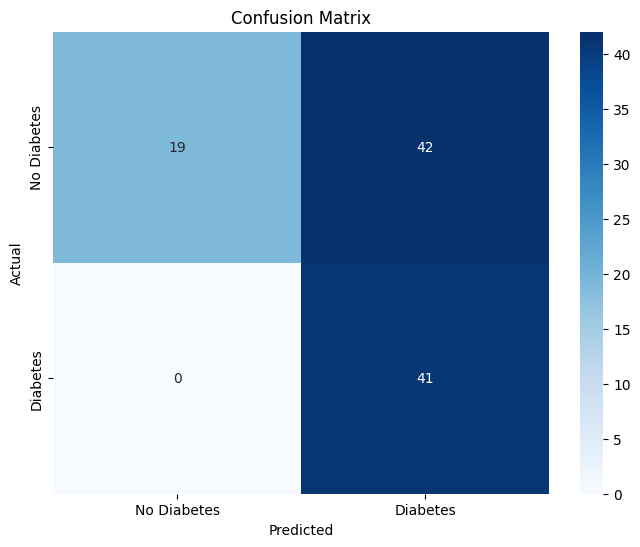

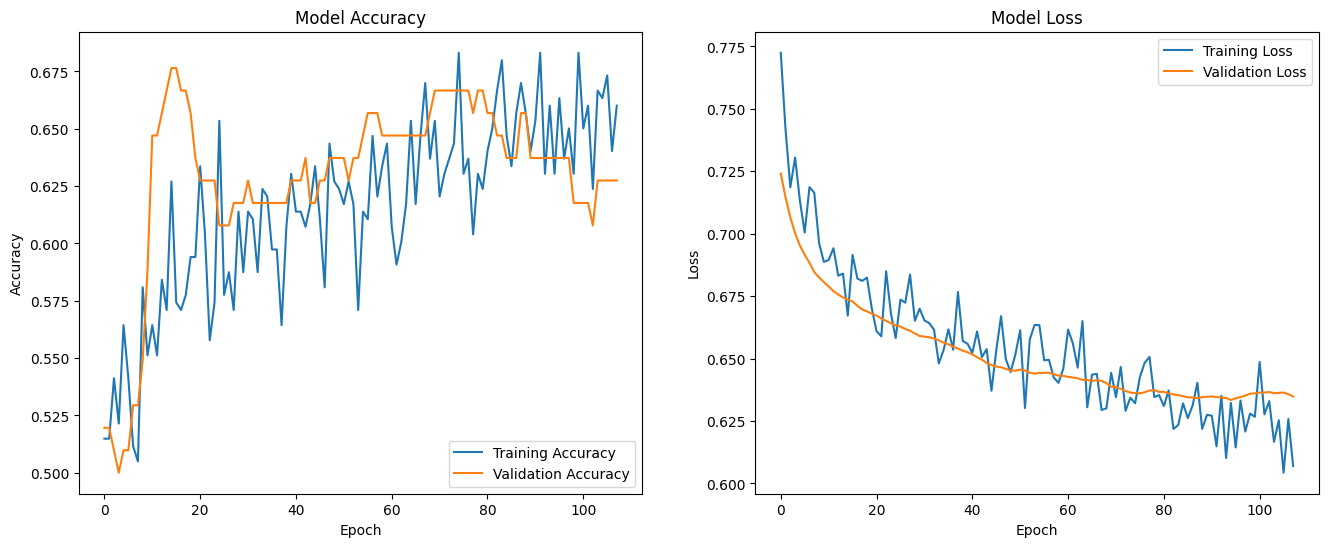


Evaluation script finished.


In [3]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib
import os

# --- Step 1: Load All Saved Artifacts ---
MODEL_FILE = 'diabetes_model.keras'
SCALER_FILE = 'scaler.joblib'
HISTORY_FILE = 'training_history.csv'

if not all(os.path.exists(f) for f in [MODEL_FILE, SCALER_FILE, HISTORY_FILE]):
    print("Error: One or more required files are missing (model, scaler, or history).")
    print("Please run the 'train_model.py' script first to create all necessary files.")
else:
    print("Loading the trained model, scaler, and history...")
    model = tf.keras.models.load_model(MODEL_FILE)
    scaler = joblib.load(SCALER_FILE)
    history_df = pd.read_csv(HISTORY_FILE)
    print("All artifacts loaded successfully.")

    # --- Step 2: Load and Prepare Test Data ---
    file_name = '/content/preprocessed_diabetes_data.csv'
    df = pd.read_csv(file_name)
    y = df['Diabetes_Diagnosis']
    X = df.drop('Diabetes_Diagnosis', axis=1)
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Step 3: Scale Test Data ---
    columns_to_scale = ['Age', 'BMI']
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # --- Step 4: Generate Predictions ---
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.3).astype("int32")

    # --- Step 5: Display Metrics ---
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # --- Step 6: Visualize Metrics and Learning Curves ---
    print("\nGenerating visualizations...")

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot Learning Curves (This section is now restored)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.plot(history_df['accuracy'], label='Training Accuracy')
    ax1.plot(history_df['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    ax2.plot(history_df['loss'], label='Training Loss')
    ax2.plot(history_df['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    plt.show()

    print("\nEvaluation script finished.")

In [4]:
import joblib
import pandas as pd
import numpy as np

# Load and examine the scaler
scaler = joblib.load('scaler.joblib')

print("=== SCALER DEBUG ===")
print(f"Scaler type: {type(scaler)}")
print(f"Feature names (if available): {getattr(scaler, 'feature_names_in_', 'Not available')}")
print(f"Scaler mean_: {scaler.mean_}")
print(f"Scaler scale_: {scaler.scale_}")
print(f"Scaler var_: {scaler.var_}")

# Test with your input values
test_data = pd.DataFrame({
    'Age': [40.0],
    'BMI': [35.16]
})

print("\n=== ORIGINAL VALUES ===")
print(test_data)

print("\n=== SCALED VALUES ===")
scaled = scaler.transform(test_data)
print(f"Scaled Age: {scaled[0][0]}")
print(f"Scaled BMI: {scaled[0][1]}")

print("\n=== EXPECTED REASONABLE SCALED VALUES ===")
print("Age 40 should scale to roughly -1 to +2 range")
print("BMI 35.16 should scale to roughly -2 to +3 range")

# Let's see what the reverse transform gives us
print("\n=== REVERSE TRANSFORM TEST ===")
try:
    original = scaler.inverse_transform(scaled)
    print(f"Reverse transformed: Age={original[0][0]:.2f}, BMI={original[0][1]:.2f}")
except Exception as e:
    print(f"Error in reverse transform: {e}")

# Check if scaler was trained on reasonable data
if hasattr(scaler, 'mean_') and len(scaler.mean_) >= 2:
    print(f"\n=== TRAINING DATA STATISTICS (from scaler) ===")
    print(f"Age - Mean: {scaler.mean_[0]:.2f}, Std: {np.sqrt(scaler.var_[0]):.2f}")
    if len(scaler.mean_) > 1:
        print(f"BMI - Mean: {scaler.mean_[1]:.2f}, Std: {np.sqrt(scaler.var_[1]):.2f}")

=== SCALER DEBUG ===
Scaler type: <class 'sklearn.preprocessing._data.StandardScaler'>
Feature names (if available): ['Age' 'BMI']
Scaler mean_: [0.39039904 0.51085062]
Scaler scale_: [0.30099801 0.19250775]
Scaler var_: [0.0905998  0.03705924]

=== ORIGINAL VALUES ===
    Age    BMI
0  40.0  35.16

=== SCALED VALUES ===
Scaled Age: 131.59423025570058
Scaled BMI: 179.98833110324017

=== EXPECTED REASONABLE SCALED VALUES ===
Age 40 should scale to roughly -1 to +2 range
BMI 35.16 should scale to roughly -2 to +3 range

=== REVERSE TRANSFORM TEST ===
Reverse transformed: Age=40.00, BMI=35.16

=== TRAINING DATA STATISTICS (from scaler) ===
Age - Mean: 0.39, Std: 0.30
BMI - Mean: 0.51, Std: 0.19


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import joblib

# --- Load the Trained Model ---
MODEL_FILE = 'diabetes_model.keras'

def load_model_only():
    """Load only the model, skip the problematic scaler."""
    if not os.path.exists(MODEL_FILE):
        print(f"Error: Model file not found.")
        return None

    print(f"Loading model from '{MODEL_FILE}'...")
    model = tf.keras.models.load_model(MODEL_FILE)
    print("Model loaded successfully.")
    return model

def interactive_prediction_no_scaling(model):
    """Interactive prediction WITHOUT using the corrupted scaler."""
    if model is None:
        return

    print("\n--- Interactive Diabetes Risk Prediction (No Scaling) ---")
    print("Please enter the following details:")

    try:
        # --- Collect User Input ---
        age = float(input("Enter Age (e.g., 35): "))
        gender_str = input("Enter Gender ('female' or 'male'): ").lower().strip()
        gender = 0 if gender_str == 'female' else 1

        history_str = input("Family history of diabetes? ('yes' or 'no'): ").lower().strip()
        family_history = 1 if history_str == 'yes' else 0

        bp_str = input("Have you ever had high blood pressure? ('yes' or 'no'): ").lower().strip()
        high_bp = 1 if bp_str == 'yes' else 0

        exercise_str = input("Enter exercise frequency ('never', '1-2 times', '3-4 times', '5 or more times'): ").lower().strip()
        exercise_map = {
            'never': 0,
            '1-2 times': 1,
            '3-4 times': 2,
            '5 or more times': 3
        }
        exercise_freq = exercise_map.get(exercise_str, 0)

        weight_kg = float(input("Enter Weight in Kilograms (e.g., 70): "))
        height_cm = float(input("Enter Height in Centimeters (e.g., 175): "))

        # --- Calculate BMI ---
        height_m = height_cm / 100
        if height_m <= 0:
            print("Error: Height must be greater than zero.")
            return

        bmi = weight_kg / (height_m ** 2)

        # --- Manual scaling with reasonable values ---
        # Assuming typical ranges: Age 18-80, BMI 15-50
        age_scaled = (age - 45) / 15  # Rough standardization
        bmi_scaled = (bmi - 25) / 8   # Rough standardization

        print(f"\n--- Debug: Manual Scaling ---")
        print(f"Original Age: {age}, Scaled: {age_scaled:.3f}")
        print(f"Original BMI: {bmi:.2f}, Scaled: {bmi_scaled:.3f}")

        # --- Create input array ---
        input_array = np.array([[age_scaled, gender, family_history, high_bp, exercise_freq, bmi_scaled]], dtype=np.float32)

        print(f"Final input: {input_array}")

        # --- Make Prediction ---
        prediction_prob = model.predict(input_array, verbose=0)[0][0]

        print(f"\n--- Debug: Raw Prediction ---")
        print(f"Raw probability: {prediction_prob}")

        # --- Determine risk level ---
        prediction_class = "High Risk" if prediction_prob > 0.5 else "Low Risk"

        # --- Display the Result ---
        print("\n--- Prediction Result ---")
        print(f"The model predicts a '{prediction_class}' of diabetes.")
        print(f"Confidence Score (Probability): {prediction_prob:.2%}")
        print("-------------------------\n")

    except ValueError as e:
        print(f"\nError: Invalid input - {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()

# --- Test with different scaling approaches ---
def test_multiple_scaling_approaches(model):
    """Test the same input with different scaling methods."""
    # Test data: Age=40, Gender=1, Family_History=1, High_BP=1, Exercise=0, BMI=35.16

    print("\n=== TESTING DIFFERENT SCALING APPROACHES ===")

    # Approach 1: No scaling
    input1 = np.array([[40, 1, 1, 1, 0, 35.16]], dtype=np.float32)
    pred1 = model.predict(input1, verbose=0)[0][0]
    print(f"No scaling: {pred1:.4f}")

    # Approach 2: Light scaling
    input2 = np.array([[(40-45)/15, 1, 1, 1, 0, (35.16-25)/8]], dtype=np.float32)
    pred2 = model.predict(input2, verbose=0)[0][0]
    print(f"Light scaling: {pred2:.4f}")

    # Approach 3: Z-score with typical population stats
    input3 = np.array([[(40-50)/20, 1, 1, 1, 0, (35.16-27)/6]], dtype=np.float32)
    pred3 = model.predict(input3, verbose=0)[0][0]
    print(f"Population Z-score: {pred3:.4f}")

    # Approach 4: Min-max scaling (assuming Age 18-80, BMI 15-50)
    input4 = np.array([[(40-18)/(80-18), 1, 1, 1, 0, (35.16-15)/(50-15)]], dtype=np.float32)
    pred4 = model.predict(input4, verbose=0)[0][0]
    print(f"Min-max scaling: {pred4:.4f}")

# --- Main execution ---
if __name__ == '__main__':
    loaded_model = load_model_only()
    if loaded_model:


        # Test different approaches
        test_multiple_scaling_approaches(loaded_model)

        # Interactive session
        while True:
            interactive_prediction_no_scaling(loaded_model)
            another = input("Do you want to make another prediction? (yes/no): ").lower().strip()
            if another != 'yes':
                print("Exiting interactive session.")
                break

Loading model from 'diabetes_model.keras'...
Model loaded successfully.

=== TESTING DIFFERENT SCALING APPROACHES ===
No scaling: 0.5246
Light scaling: 0.7107
Population Z-score: 0.7057
Min-max scaling: 0.6952

--- Interactive Diabetes Risk Prediction (No Scaling) ---
Please enter the following details:
